In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_log_error,make_scorer,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve,KFold
from sklearn.inspection import plot_partial_dependence

In [74]:
warnings.filterwarnings(action = 'ignore')

# Data preprocecing

In [165]:
train = pd.read_csv("C:/Users/whileduck/Downloads/playground-series-s3e11/train.csv")
test = pd.read_csv("C:/Users/whileduck/Downloads/playground-series-s3e11/test.csv")

In [166]:
df = train.copy()

In [167]:
df.drop('id', axis = 1,inplace = True)

In [168]:
def binary_category_numeric(data):
    
    binary = []
    category = []
    numeric = []
    
    for col in data.columns:
        
        if data[col].nunique() ==2:
            binary.append(col)
        elif (2 < data[col].nunique()) and (data[col].nunique() < 20):
            category.append(col)
        else:
            numeric.append(col)
            
    print('Binary Columns : ',binary)
    print('Category Columns : ',category) 
    print('Numeric Columns : ',numeric)
    
    return binary,category,numeric

In [169]:
binary,category,numeric = binary_category_numeric(df.drop('cost',axis = 1))

Binary Columns :  ['recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
Category Columns :  ['unit_sales(in millions)', 'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1']
Numeric Columns :  ['store_sales(in millions)', 'gross_weight', 'units_per_case', 'store_sqft']


# EDA

Text(0.5, 0.98, 'Binary Feature Boxplot and KDE')

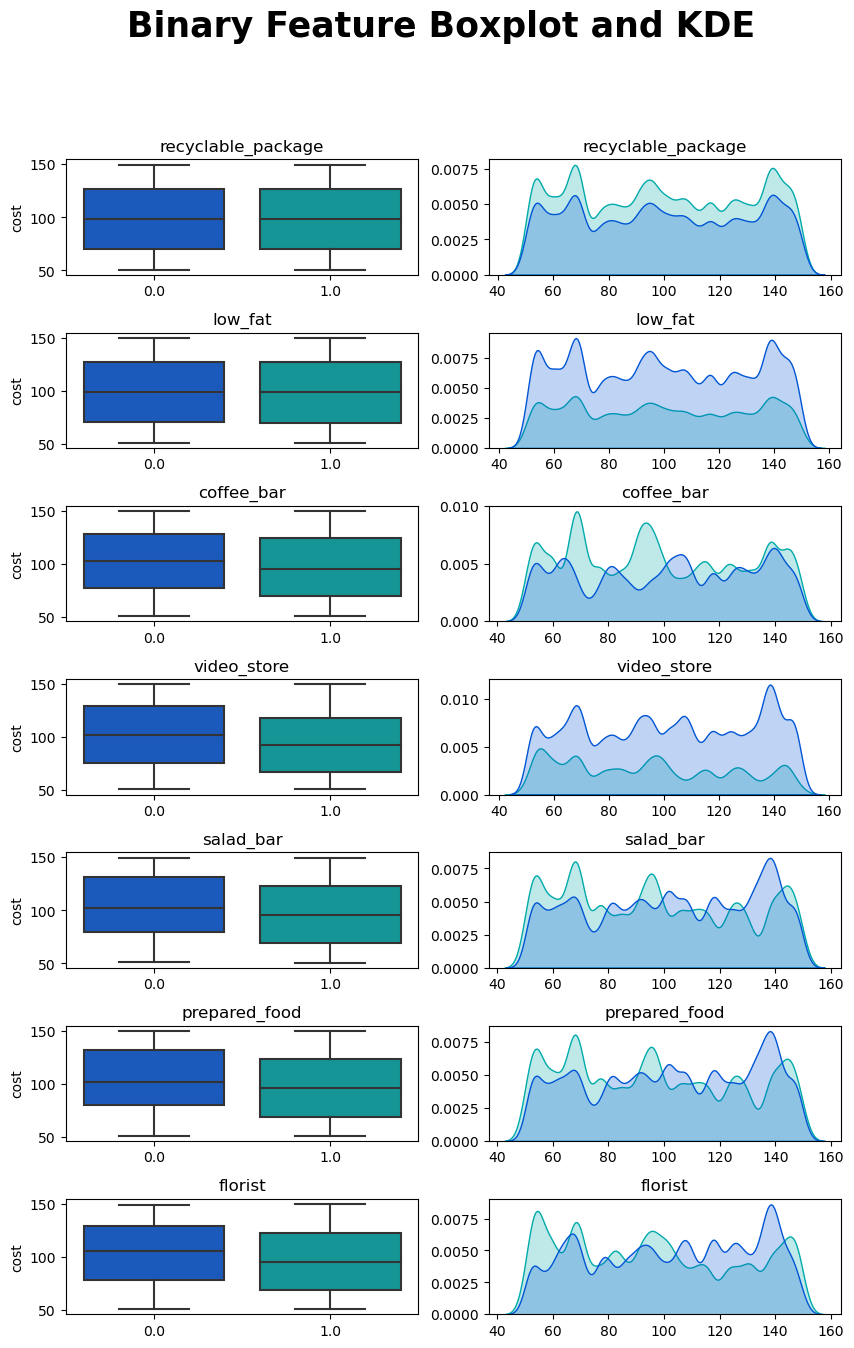

In [172]:
plt.figure(figsize = [10,15])
plt.subplots_adjust(hspace = 0.5)

i  = 1
j = 2

for col in binary:
    
    plt.subplot(7,2,i)
    
    sns.boxplot(data = df,
                x = col,
                y = 'cost',
                palette = 'winter')
    plt.title(col)
    plt.xlabel('')
    
    plt.subplot(7,2,j)
    
    sns.kdeplot(data = df,
                x = 'cost',
                hue = col,
                fill = 'stack',
                palette = 'winter',
                shade = True,
                legend = False)
    plt.title(col)
    plt.ylabel('')
    plt.xlabel('')
    
    i += 2
    j += 2
    
plt.suptitle('Binary Feature Boxplot and KDE', 
             fontsize = 25, fontweight = 'bold',
             ha = 'center')
    
    

Text(0.5, 0.98, 'Category Feature Boxplot')

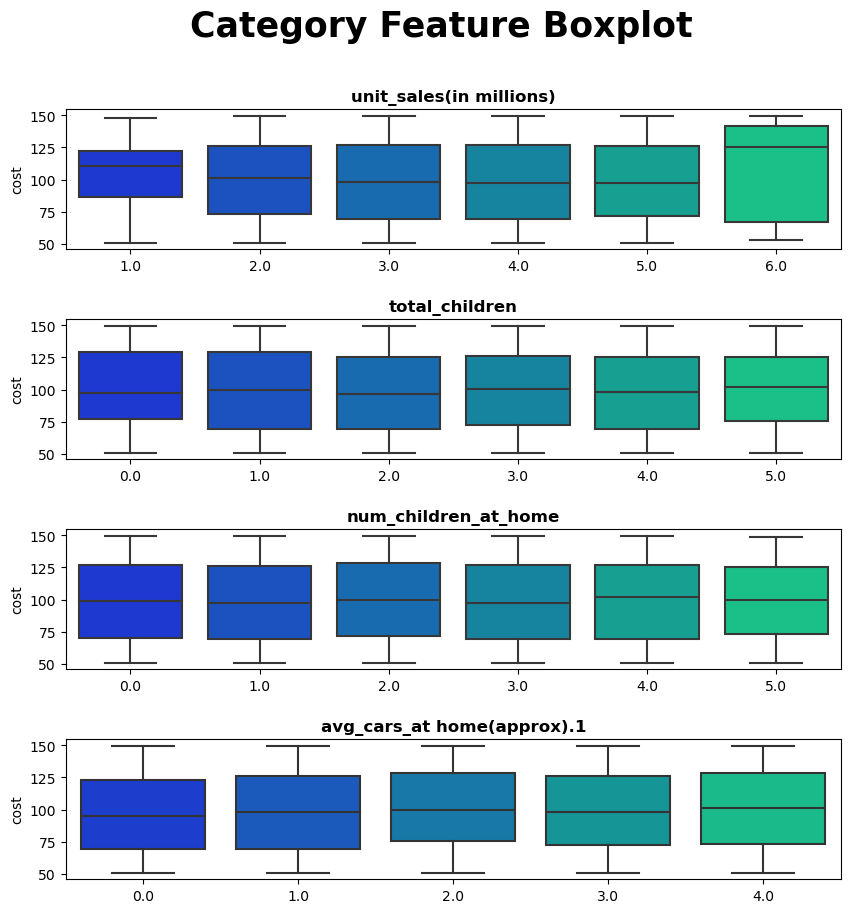

In [201]:
fig,ax = plt.subplots(nrows = len(category),
                      figsize = [10,10])

plt.subplots_adjust(hspace = 0.5)

ax = ax.flatten()

for i,col in enumerate(category):
    
    sns.boxplot(data = df,
                x = col,
                y = 'cost',
                palette = 'winter',
                ax = ax[i])
    ax[i].set_title(col, fontweight = 'bold')
    ax[i].set_xlabel('')
    
plt.suptitle('Category Feature Boxplot',
             fontsize = 25,fontweight = 'bold',
             ha = 'center')
    
    

Text(0.5, 0.98, 'Bining Numeric Feature histplot')

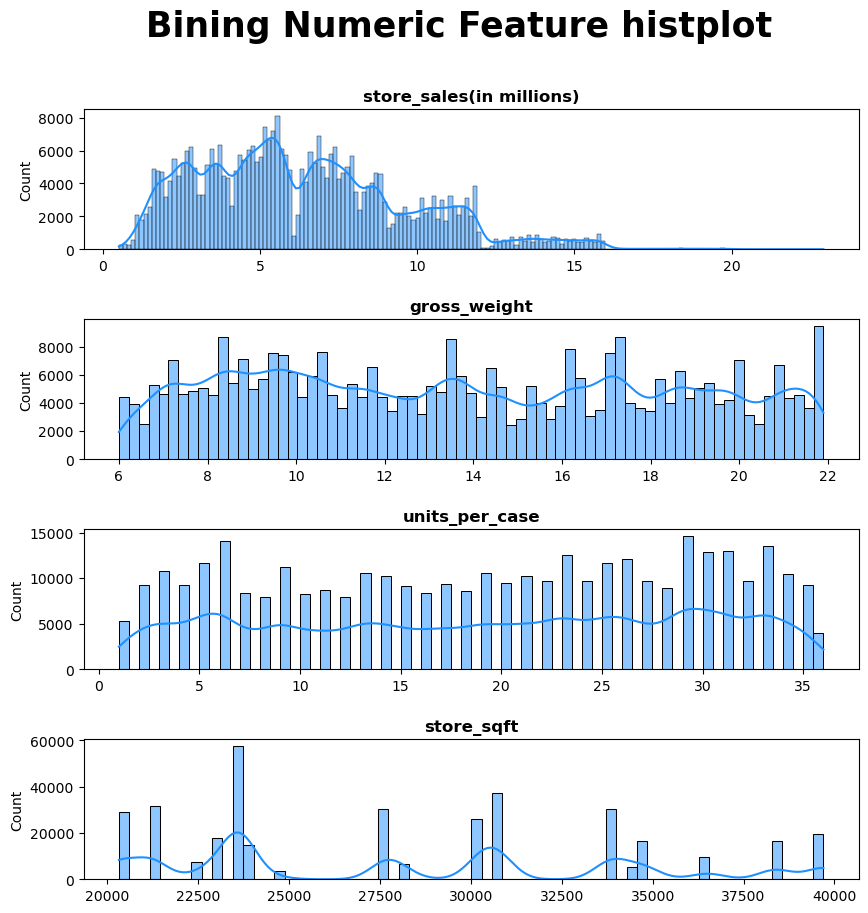

In [206]:
fig,ax = plt.subplots(nrows = len(numeric),
                      figsize = [10,10])

plt.subplots_adjust(hspace = 0.5)

ax = ax.flatten()

for i,col in enumerate(numeric):
    
    sns.histplot(data = df,
                 x = col,
                 kde = True,
                 ax = ax[i],
                 color = 'dodgerblue')
    ax[i].set_title(col, fontweight = 'bold')
    ax[i].set_xlabel('')
    
plt.suptitle('Bining Numeric Feature histplot',
             fontsize = 25,fontweight = 'bold',
             ha = 'center')
    

# Modeling

In [241]:
X = df.drop('cost', axis = 1)
Y = np.log(df['cost'])

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42,
                                                 stratify = Y)

# Gradient Boosting Regressor

In [312]:
xgb_params = {
    'booster': 'gbtree',
    'objective' : 'reg:squarederror',
    'eval_metric':'rmse', 
    'learning_rate': 0.1,
    'max_depth': 8,
    'n_estimators': 9999,
    'early_stopping_rounds': 200,
    'tree_method':'gpu_hist',
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'seed': 42
}

fold = KFold(n_splits = 5, shuffle = True)

models = []
fold_scores = []
best_iteration = []
feature_importance = np.zeros(x_train.shape[1])

for i, (train_idx,valid_idx) in enumerate(fold.split(x_train,y_train)):
    
    
    train_x,train_y = x_train.iloc[train_idx],y_train.iloc[train_idx]
    valid_x,valid_y = x_train.iloc[valid_idx],y_train.iloc[valid_idx]
    xgb = XGBRegressor(**xgb_params)
    
    xgb.fit(train_x,train_y,
                       eval_set = [(train_x,train_y),(valid_x,valid_y)],
                       verbose = 0)
        
    fold_score = mean_squared_log_error(np.exp(valid_y), np.exp(xgb.predict(valid_x)), squared=False)
    
    models.append(xgb)
    
    print('**' * 20)
    print(i+1,"Fold Set's RMSE :",fold_score)
    print('**' * 20)
    
    fold_scores.append(fold_score)
    
    feature_importance += xgb.feature_importances_
    
    
    best_iteration.append(xgb.best_ntree_limit)
    

mean_featue_importance = feature_importance / i

Importance = pd.DataFrame({'columns':x_train.columns,
              'Feature_importance':mean_featue_importance})

****************************************
1 Fold Set's RMSE : 0.29696522323788316
****************************************
****************************************
2 Fold Set's RMSE : 0.29721177428476936
****************************************
****************************************
3 Fold Set's RMSE : 0.29818656390052317
****************************************
****************************************
4 Fold Set's RMSE : 0.29795276211172134
****************************************
****************************************
5 Fold Set's RMSE : 0.29795015670121067
****************************************


In [289]:
print('RMSE Average Score : ', np.mean(fold_scores))
print('Best Iteration : ',best_iteration)

RMSE Average Score :  0.29782427593835586
Best Iteration :  [133, 97, 147, 169, 109]


# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

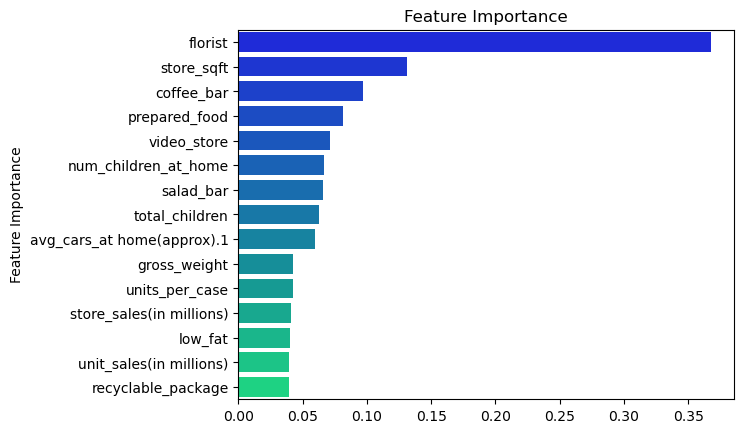

In [316]:
Importance = Importance.sort_values(by = 'Feature_importance',ascending = False)

sns.barplot(data = Importance,
            x = 'Feature_importance',
            y = 'columns',
            palette = 'winter')
plt.xlabel('')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')

In [331]:
submission = pd.read_csv("C:/Users/whileduck/Downloads/playground-series-s3e11/sample_submission.csv")

test.drop('id',axis = 1, inplace = True)

In [366]:
result = pd.DataFrame()

for i in range(5):
        
    result[f'cost{i}'] = models[i].predict(test)

In [347]:
submission['cost']= np.exp((result['cost0'] + result['cost1'] + result['cost1'] + result['cost1'] + result['cost1'])/ 5)

In [348]:
submission

,id,cost
0,360336,91.697235
1,360337,90.767319
2,360338,90.575439
3,360339,100.180313
4,360340,77.010567
...,...,...
240219,600555,98.512444
240220,600556,92.062660
240221,600557,95.095222
240222,600558,101.181145


In [349]:
submission.to_csv('submission.csv',index = False)